In [85]:
# Imports:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Sklearn:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
# Other:
from scipy.stats import shapiro
from scipy.stats import iqr

# Data:
pd.set_option('display.max_columns', None)
df_co2 = pd.read_excel('Mobiliteitsdata.xlsx')
print("Head of the data")
display(df_co2.head())
print("Column list")
display(df_co2.columns.tolist())
pd.set_option('display.max_columns', 10)

Head of the data


,persoon_ID,geslacht,leeftijd,gewicht_KG,burgerlijke_staat,jaarsalaris_eu,huishouden_grootte,stad,provincie,opleiding_niveau,autobezit,fietsbezit,elektrisch_auto,km_auto_per_jaar,km_fiets_per_jaar,km_ov_per_jaar,km_vliegtuig_per_jaar,dagen_thuiswerken_per_week_pro_rato,dagen_kantoorwerken_per_week_pro_rato,dagen_in_buitenland_per_jaar,gebruik_carsharing,co2_uitstoot_per_jaar_KG
0,811069,man,50,52.66,weduwe/weduwnaar,48003.64,5,Almere,Flevoland,MBO,ja,ja,nee,13266.05,2040.54,3227.95,480.71,4,1,20,Nooit,7591.93
1,246882,vrouw,65,64.58,samenwonend,55208.63,2,Leeuwarden,Overijssel,WO,ja,nee,nee,15229.89,0.00,2298.96,1423.34,5,0,7,Heel soms,8742.25
2,978385,man,49,90.87,samenwonend,29533.78,2,Tilburg,Utrecht,HBO,ja,ja,ja,19853.24,1540.46,4504.21,632.48,4,1,2,Altijd,4513.56
3,120468,man,34,80.43,gehuwd,44453.27,2,Maastricht,Utrecht,HBO,ja,ja,nee,9935.50,1825.92,4407.56,1266.84,3,2,21,Heel soms,6904.41
4,637034,man,60,72.28,ongehuwd,56497.64,2,Leiden,Gelderland,MBO,ja,ja,ja,16266.67,1851.07,1936.12,1676.00,0,5,0,Nooit,4420.80


Column list


['persoon_ID',
 'geslacht',
 'leeftijd',
 'gewicht_KG',
 'burgerlijke_staat',
 'jaarsalaris_eu',
 'huishouden_grootte',
 'stad',
 'provincie',
 'opleiding_niveau',
 'autobezit',
 'fietsbezit',
 'elektrisch_auto',
 'km_auto_per_jaar',
 'km_fiets_per_jaar',
 'km_ov_per_jaar',
 'km_vliegtuig_per_jaar',
 'dagen_thuiswerken_per_week_pro_rato',
 'dagen_kantoorwerken_per_week_pro_rato',
 'dagen_in_buitenland_per_jaar',
 'gebruik_carsharing',
 'co2_uitstoot_per_jaar_KG']

# Deel A: Data exploratie en voorbereiding

1.	Geef voor elke variabele in de dataset weer tot welk meetniveau deze behoort.

| Variabele | Meetniveau |
| --- | --- |
| persoon_ID | Geen |
| geslacht | Nominaal |
| leeftijd | Ratio |
| gewicht_KG | Ratio |
| burgerlijke_staat | Nominaal |
| jaarsalaris_eu | Ratio |
| huishouden_grootte | Ratio |
| stad | Nominaal |
| provincie | Nominaal |
| opleiding_niveau | Ordinaal |
| autobezit | Nominaal |
| fietsbezit | Nominaal |
| elektrisch_auto | Nominaal |
| km_auto_per_jaar | Ratio |
| km_fiets_per_jaar | Ratio |
| km_ov_per_jaar | Ratio |
| km_vliegtuig_per_jaar | Ratio |
| dagen_thuiswerken_per_week_pro_rato | Ratio |
| dagen_kantoorwerken_per_week_pro_rato | Ratio |
| dagen_in_buitenland_per_jaar | Ratio |
| gebruik_carsharing | Ordinaal |
| co2_uitstoot_per_jaar_KG | Ratio |

In [3]:
# 1
# Gemaakt in markdown. Wellicht dat we al eerder het ID droppen? Deze gaan we toch niet gebruiken
# Mischien ook verstandig om hier ook toelichting bij te geven als dit nodig is?

2.	Waarom is het nodig om vooraf te bekijken tot welk meetniveau elke variabele behoort?

Dit helpt ons om te bepalen welke statistische methode we gaan gebruiken en om te bepalen hoe we de data gaan voorbewerken.<br>
(Mischien nog wat dieper op in gaan)

In [4]:
# 2

3.	Ga na of er missende/niet kloppende/extreme waarden zijn in de dataset en ga hier op een adequate manier mee om.

Missende waarden percentage
co2_uitstoot_per_jaar_KG    0.47
jaarsalaris_eu              0.07
stad                        0.07
opleiding_niveau            0.07
autobezit                   0.07
dtype: float64
Extreme waarden gedetecteerd in: co2_uitstoot_per_jaar_KG


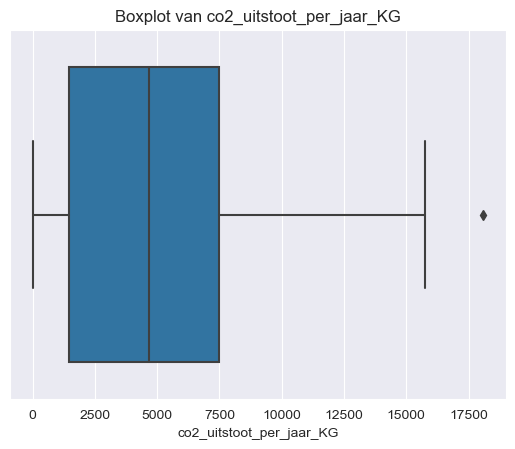

Extreme waarden gedetecteerd in: gewicht_KG


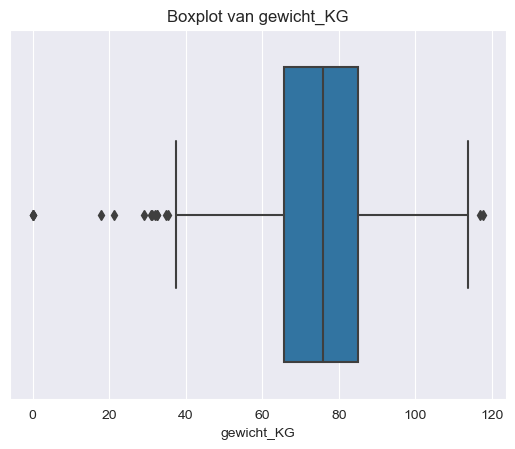

Extreme waarden gedetecteerd in: jaarsalaris_eu


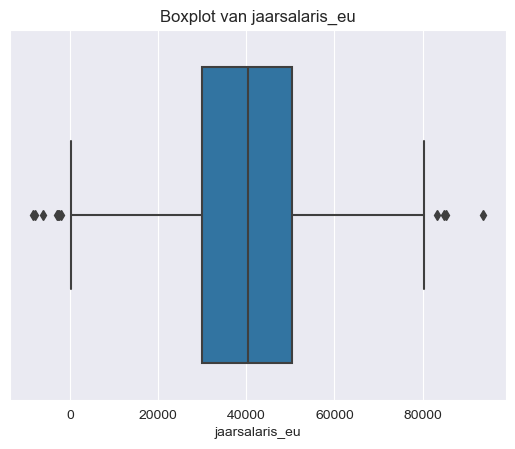

Extreme waarden gedetecteerd in: km_auto_per_jaar


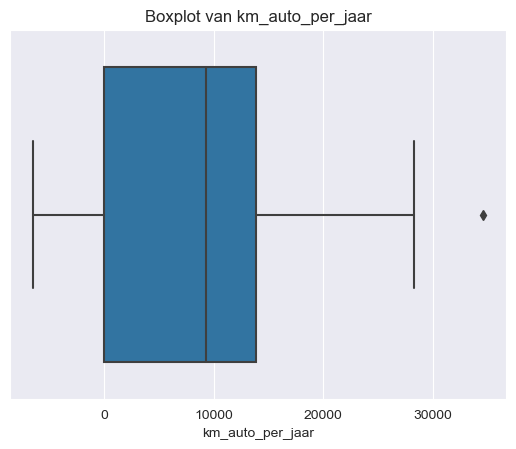

Extreme waarden gedetecteerd in: km_ov_per_jaar


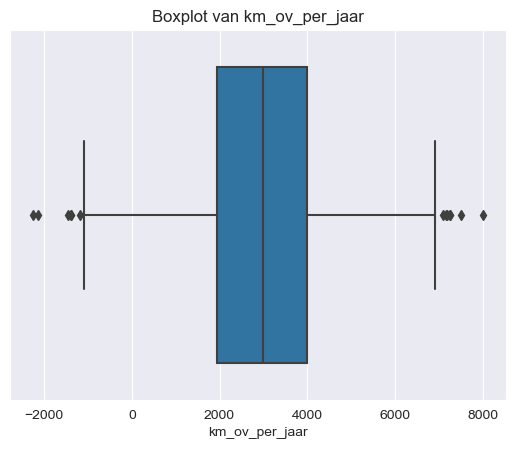

Extreme waarden gedetecteerd in: km_vliegtuig_per_jaar


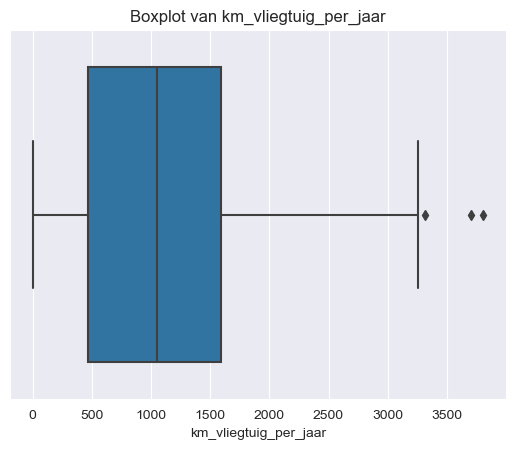

In [5]:
# 3
# import z-score
from scipy.stats import zscore
# Eerst missende waarden:
mv = df_co2.isnull().mean() * 100
print("Missende waarden percentage")
print(mv[mv > 0].sort_values(ascending=False).round(2))

# Extreme waarden
# Instellingen
threshold = 3
columns_to_check = df_co2.select_dtypes(include=[np.number]).columns.difference(['persoon_ID'])

# Loop voor relevante kollomen
for col in columns_to_check:
    z_scores = zscore(df_co2[col].dropna())
    extreme_mask = np.abs(z_scores) > threshold

    if extreme_mask.any():
        print(f"Extreme waarden gedetecteerd in: {col}")
        sns.boxplot(x=df_co2[col])
        plt.title(f"Boxplot van {col}")
        plt.show()

4.	Kies 2 onafhankelijke variabelen waarvan je denkt dat het invloed kan hebben op de jaarlijkse CO2 uitstoot. Visualiseer de verdeling van deze twee variabelen en de verdeling van de afhankelijke variabele.

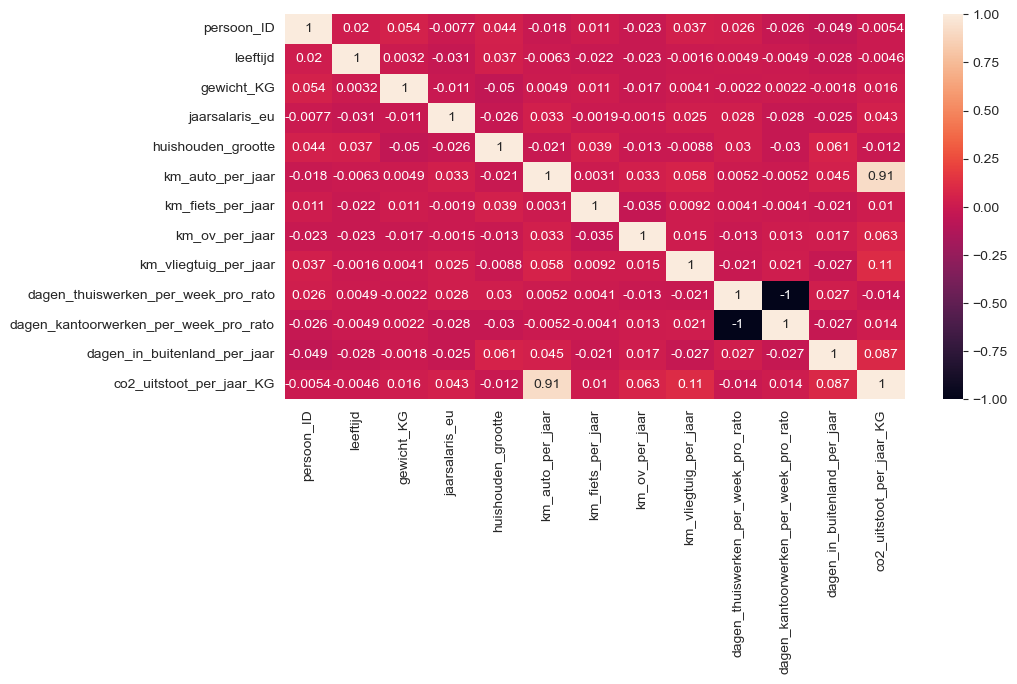

C:\Users\mkako\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


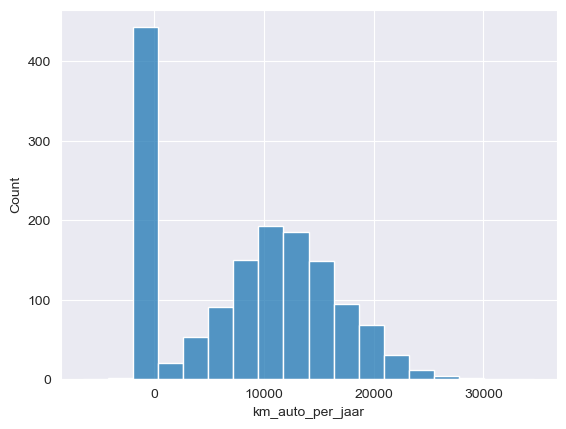

C:\Users\mkako\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


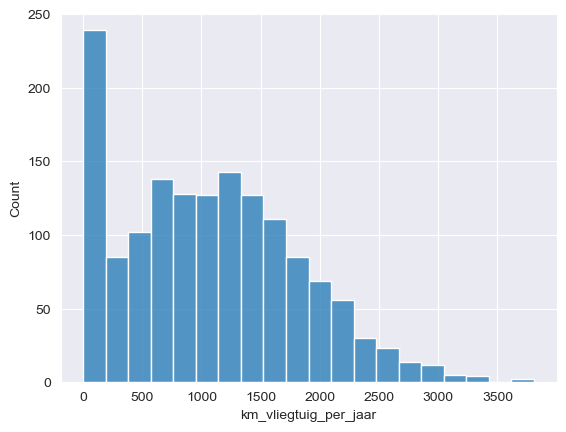

C:\Users\mkako\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


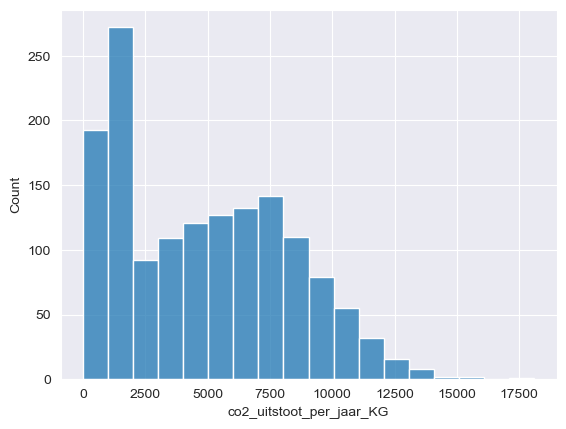

In [40]:
# 4
# Twee kolommen die ik heb gekozen met potential correlatie/invloed op "co2_uitstoot_per_jaar_KG" zijn: "km_auto_per_jaar" en "km_vliegtuig_per_jaar". Ik heb voor deze twee kolommen gekozen, omdat deze twee vervoermiddelen worden vaak gebruikt en gebruiken ook veel brandstof. Deze variabelen zijn ook afhankelijk van elkaar, omdat een heeft geen echte invloed op de ander.
numeric_cols = df_co2.select_dtypes(include=['int64', 'float64']).columns
df_numeric = df_co2[numeric_cols]
plt.figure(figsize=(10, 5))
sns.heatmap(df_numeric.corr(), annot=True)
plt.show()
# Op de heatmap kan je zien dat ik had wel gelijk en deze twee variabelen hadden het grootste invloed. In het geval van de auto's er is een heel grote (bijna perfecte) positive correlatie, maar wat verrassing is, is dat hoewel vliegtuigen het tweede hoogste correlatie hierbij hebben die is nog steeds heel klein. Dit is een zwake positive correlatie dat betekent dat gebruiken van vliegtuigen heeft kleine invloed op co2 uitstoot per jaar in kilograms per kilometer. Het is belangrijk om te merken dat vliegtuigen worden gebruikt om grotere afstanden te reisen in kleine tijden en dus terwijl co2 productie per km kan veel minder zijn voor vliegtuigen, de totaal co2 uitstoot per jaar van vliegtuigen is nog steeds iets om overwegen.
car_kpy = df_co2['km_auto_per_jaar']
plane_kpy = df_co2['km_vliegtuig_per_jaar']
co2_py = df_co2['co2_uitstoot_per_jaar_KG']
#sns.regplot(x=car_kpy, y=co2_py)
#plt.show()
#sns.regplot(x=plane_kpy, y=co2_py)
#plt.show()

# Ik heb voor hist plot gekozen, omdat die laat zien verdelingen goed.
# Er zijn geen afhankelijk variabelen met echte invloed (behalve co2 zelf) waarmee de correlatie zou groot zijn (alles minder dan 0.1 corr).
def hist_plot_maker(data, x):
    sns.histplot(data=data, x=x)
    plt.show()
hist_plot_maker(df_co2, car_kpy)
hist_plot_maker(df_co2, plane_kpy)
hist_plot_maker(df_co2, co2_py)

5.	Geef een beschrijving van de 3 visualisaties met behulp van statistische termen.

In [88]:
# 5
# Bij alle visualizes er is grote hoeveelheid van data met ≈0 waarden, dit heeft een invloed bij de spread en verdeling van de data en betekent ook dat data is niet altijd qua statistieken "netjes" verdeeld. Het is ook de rede waarom ik heb gekozen om IQR in plaats van bereik te gebruiken.
def show_statistics(var):
    print(var.describe())
    print(f"Median: {var.median()}")
    print(f"Skewness: {var.skew()}")
    print(f"Kurtosis: {var.kurt()}")
    print(f"IQR: {iqr(var)}")
#1 (km_auto_per_jaar): Zonder extreme waarden mean, mode en mediaan zijn in ongeveer hetzelfde plek. Er is geen Skewness.
print("--- km_auto_per_jaar ---")
show_statistics(car_kpy)
#2 (km_vliegtuig_per_jaar): Er is grootste getallen op de linkerkant van de plot met kleinste getallen op de rechterkant. Dit geeft aan rechte/positive Skewness van 0.414 (kleine "tail" op rechte kant), met negatieve Kurtosis van -0.34, dus de "peak" is best wel "flat" in vergelijking met normaal verdeeld data.
print("--- km_vliegtuig_per_jaar ---")
show_statistics(plane_kpy)
#3 (co2_uitstoot_per_jaar_KG): Vergelijkbare rechte Skewness met plot #2 (0.440) maar dan met grootse negative Kurtosis, dus te "peak" is nog meer "flatter".
print("--- co2_uitstoot_per_jaar_KG ---")
show_statistics(co2_py)

--- km_auto_per_jaar ---
count     1500.000000
mean      8597.262393
std       7021.428530
min      -6506.630000
25%          0.000000
50%       9356.380000
75%      13842.732500
max      34618.870000
Name: km_auto_per_jaar, dtype: float64
Median: 9356.380000000001
Skewness: 0.1678828783231597
Kurtosis: -0.960381076063419
IQR: 13842.7325
--- km_vliegtuig_per_jaar ---
count    1500.000000
mean     1072.277327
std       748.651072
min         0.000000
25%       471.540000
50%      1052.140000
75%      1588.555000
max      3808.200000
Name: km_vliegtuig_per_jaar, dtype: float64
Median: 1052.1399999999999
Skewness: 0.41399042702396605
Kurtosis: -0.3404479466219743
IQR: 1117.015
--- co2_uitstoot_per_jaar_KG ---
count     1493.000000
mean      4912.341875
std       3422.902397
min          0.000000
25%       1469.450000
50%       4677.280000
75%       7481.550000
max      18098.440000
Name: co2_uitstoot_per_jaar_KG, dtype: float64
Median: 4677.28
Skewness: 0.44059068170121335
Kurtosis: -0.70

6.	Toets, met behulp van statistiek, of de verdelingen (vraag 4) normaal verdeeld zijn.

In [89]:
# 6
# Ik heb een functie gemaakt die gebruikt shapiro om te berekenen of de verdelingen normaal verdeeld zijn. Dit is niet 100% accuraat maar met berekeningen uit vorige opdracht met statistieken krijg ik een goede beeld van de verdeling. Ik heb hierbij threshold van 0.05 p gezet, omdat dit de norm is in bepalen of de verschil klein genoeg is. Als die p groter is dan de threshold, dan de data is normaal verdeeld.
def normaal_verdeeld(var):
    stat, p = shapiro(var)
    print(f"Normaal Verdeeld: {p > 0.05} ({p})")

print("--- km_auto_per_jaar ---")
normaal_verdeeld(car_kpy)
print("--- km_vliegtuig_per_jaar ---")
normaal_verdeeld(plane_kpy)
print("--- co2_uitstoot_per_jaar_KG ---")
normaal_verdeeld(co2_py) # p van 1 kan hier niet kloppen...

--- km_auto_per_jaar ---
Normaal Verdeeld: False (8.351651722054391e-28)
--- km_vliegtuig_per_jaar ---
Normaal Verdeeld: False (1.8340720034474885e-18)
--- co2_uitstoot_per_jaar_KG ---
Normaal Verdeeld: True (1.0)


7.	Om ervoor te zorgen dat de onafhankelijke variabelen gebruikt kunnen worden voor Machine Learning moeten ze getransformeerd worden. Geef per meetniveau aan wat er moet gebeuren en waarom.

In [9]:
# 7
# In ider geval de data moet in de vorm van dataframe of numpy array zijn zonder null waarden en numerieke waarden.
# Nominaal: Categorische data zonder volgorde moet worden omgezet naar dummyvariabelen, zodat het model de categorieën kan gebruiken zonder te denken dat er een volgorde is.
# Ordinaal: Data moet naar numerieke waarden geconverteerd worden (mapping), zodat ze in een model kunnen worden ingevuld en voorspeld worden.
# Interval: Standardizatie (Z-scoren) uitvoeren om data op schaal te krijgen, zodat de data gelijk verdeeld is op de schaal bij verschillende variabelen.
# Ratio: Hetzelfde als bij Interval.

8.	Voer de transformatie uit. Let op dat je de getransformeerde variabelen in een nieuw dataframe opslaat, zodat je de oorspronkelijke waarden behoudt. De getransformeerde variabelen gebruik je alleen bij deel D. Zorg dat je inzicht krijgt in de relatie tussen de variabelen. Wat zijn je bevindingen?

In [10]:
# 8

9.	Welke methode(n) heb je gebruikt en waarom?

In [11]:
# 9

10.	Is er sprake van multicollineariteit? Waarom zou dit een probleem kunnen zijn en wat zou jouw oplossing zijn?

In [12]:
# 10

11.	Bekijk de relatie tussen uitstoot CO2 en de andere onafhankelijke variabelen per geslacht. Kom je hier tot een andere conclusie dan bij vraag 8?

In [13]:
# 11

# Deel B: Kansrekenen

12.	Wat is de kans dat een willekeurig persoon 5000 KG CO2 uitstoot? Gebruik de standaard normaal verdeling in de berekening.

In [14]:
# 12

13.	Op welke manier wordt, bij deze berekening, een van de technieken van calculus toegepast?

In [15]:
# 13

14.	Is deze kans groter, gelijk of kleiner bij mannen t.o.v. vrouwen?

In [16]:
# 14

# Deel C: Toetsende statistiek

15.	Stel de hypothesen op.

In [17]:
# 15

16.	Welke type fouten kunnen er gemaakt worden?

In [18]:
# 16

17.	Welke statistische toets moet je uitvoeren om te onderzoeken of er een significant verschil is?

In [19]:
# 17

18.	Voer de toets uit.

In [20]:
# 18

19.	Geef in je eigen woorden een toelichting op de betekenis van de p-waarde.

In [21]:
# 19

20.	Welke conclusie kan je trekken?

In [22]:
# 20

# Deel D: Modelleren

21.	Train een model om de jaarlijkse CO2 uitstoot te voorspellen. Op hoeveel verschillende mogelijkheden kan deze split gemaakt worden?

In [23]:
# 21

22.	Train een model om de jaarlijkse CO2 uitstoot te voorspellen. Welke metric zou je gebruiken om te toetsen hoe goed je model is en waarom?


In [24]:
# 22

23.	Geef de wiskunde functie van het model en pas deze toe op jouw eigen situatie (kies 1 groepsgenoot).

In [25]:
# 23

24.	Gebruik toetsende statistiek en de resultaten van de 20-fold cross validation om te onderzoeken welk model significant beter is.

In [26]:
# 24

25.	Splits de target variabele op in 2 klassen, kies hiervoor een geschikte punt. Codeer de eerste groep als 0 en de tweede groep als 1. Welk model zou je nu kunnen gebruiken en waarom?


In [27]:
# 25

26.	Train een nieuw model op de nieuwe target, gebruik hierbij alleen de vijf meest invloedrijke onafhankelijke variabelen die je eerder hebt gekozen. Geef de wiskunde functie van dit model en pas deze toe op jouw eigen situatie (kies 1 groepsgenoot).


In [28]:
# 26

27.	Schrijf een conclusie op basis van de twee hoofdvragen van het portfolio (zie kopje ‘Vraagstellingen’)


In [29]:
# 27

###